# **U-Net — 기본 구조부터 학습 및 시각화까지**

 **U-Net 기반 이미지 세그멘테이션** 실습을 목표로 합니다.  
다운샘플(Encoder) → 업샘플(Decoder) + **Skip Connection** 구조가 **왜 분할(segmentation)에 강한지**를 직접 확인합니다.

## 학습 목표
- U-Net의 **Encoder/Decoder/Skip Connection** 흐름을 코드에서 찾을 수 있다.
- 입력/출력 텐서 shape이 단계별로 어떻게 바뀌는지 설명할 수 있다.
- 간단한 데이터셋으로 **학습 → 검증 → 예측 시각화**까지 한 번에 실행할 수 있다.
> Segmentation은 “어디에 무엇이 있는가”를 픽셀 단위로 예측합니다.  
> 그래서 U-Net은 **공간 정보(spatial detail)** 를 보존/복원하기 위한 구조적 장치를 적극적으로 사용합니다.

---

### 구성 개요

1. U-Net 개요 (이론 정리)
2. 환경 설정 & 데이터 준비
3. PyTorch U-Net 모델 구현
4. 손실함수 / 옵티마이저 설정
5. 학습 루프 (training loop)
6. 평가 및 시각화
7. 과제/확장 아이디어


---
## 0) Setup (환경 준비)

- **목적:** 실습에 필요한 패키지를 로드하고, GPU 사용 여부를 확인합니다.
- **관찰 포인트**
  - `torch.cuda.is_available()` 결과와 사용 디바이스(`cpu/cuda`)
  - (선택) 재현성을 위해 시드를 고정하는 이유


In [1]:
# 필요한 패키지가 설치되어 있는지 확인하고, 없을 때만 pip로 설치합니다.
# (재실행해도 중복 설치를 피함)
import importlib.util
import sys
import subprocess

def ensure_package(pkg_name: str, import_name=None):
    name = import_name or pkg_name
    if importlib.util.find_spec(name) is None:
        print(f"[install] {pkg_name} (import: {name})")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
    else:
        print(f"[ok] {pkg_name}")

# U-Net 실습에서 사용: 모델 요약 출력
ensure_package("torchinfo")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CUDA 상세 정보 (옵션)
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))

[ok] torchinfo
Using device: cuda
CUDA device count: 1
Current device index: 0
Device name: NVIDIA A10-24Q


---
## 1) 데이터 준비

- **목적:** 실습을 빠르게 진행하기 위해, 간단한 **Synthetic Segmentation Dataset**을 사용합니다.
- **관찰 포인트**
  - `__getitem__`이 반환하는 입력 이미지와 마스크의 shape / dtype
  - 마스크 값이 **0/1**(binary)인지, 혹은 클래스 인덱스 형태인지
  - DataLoader에서 배치로 묶였을 때 텐서 차원이 어떻게 되는지

> 실제 프로젝트에서는 공개 데이터셋(예: 의료 영상, 도로/도시 장면 등)으로 쉽게 교체할 수 있습니다.  
> 여기서는 **모델 구조/학습 흐름**에 집중하기 위해 synthetic 데이터를 사용합니다.


In [2]:
class SyntheticCircleDataset(Dataset):
    """
    매우 단순한 synthetic 데이터셋 예제입니다.

    - 입력: 1채널 이미지 (H x W)
    - 타깃: 원 모양의 binary mask
    """
    def __init__(self, length=200, image_size=128, transform=None):
        self.length = length
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 빈 이미지 생성
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        mask = np.zeros_like(img)

        # 랜덤 원 생성
        center_x = np.random.randint(self.image_size // 4, 3 * self.image_size // 4)    # 1/4 ~ 3/4
        center_y = np.random.randint(self.image_size // 4, 3 * self.image_size // 4)
        radius = np.random.randint(self.image_size // 8, self.image_size // 4)

        y, x = np.ogrid[:self.image_size, :self.image_size]
        dist_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
        mask[dist_from_center <= radius] = 1.0

        # 입력 이미지는 약간의 노이즈 + mask를 이용해 생성
        img = mask + 0.2 * np.random.randn(self.image_size, self.image_size).astype(np.float32)
        img = np.clip(img, 0.0, 1.0)

        # (H, W) -> (1, H, W)
        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)

        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)

        if self.transform is not None:
            # 필요 시 torchvision.transforms 등을 추가적으로 적용
            pass

        return img, mask

# 데이터셋/데이터로더 예시
train_dataset = SyntheticCircleDataset(length=400, image_size=128)
val_dataset   = SyntheticCircleDataset(length=100, image_size=128)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 50
Val batches: 13


---
## 2) U-Net 모델 구현

- **목적:** U-Net의 표준 블록을 구현하고, Encoder/Decoder의 연결 구조를 코드로 확인합니다.
- **관찰 포인트**
  - `DoubleConv`(Conv–BN–ReLU 반복)이 feature 추출에 어떻게 쓰이는지
  - Down path에서 **Pooling/Stride**로 해상도가 줄어드는 지점
  - Up path에서 **Up-sampling(ConvTranspose2d 또는 bilinear)** 이 적용되는 지점
  - Skip 연결 시 **concat 채널 수**가 어떻게 증가하는지(가장 흔한 shape mismatch 원인)

> 구현을 따라가면서 각 단계의 feature map 크기(H×W)와 채널(C)을 메모해 두면 이해가 훨씬 빨라집니다.


In [3]:
# =========================
# 3) U-Net 모델 정의
# =========================
# 이 섹션의 목표:
# - U-Net의 "인코더(Down) → 보틀넥 → 디코더(Up) + Skip Connection" 구조를
#   PyTorch 코드로 직접 따라가며 이해합니다.
#
# 핵심 아이디어(한 줄):
# - Down에서 공간 해상도(H,W)는 줄이고 채널(C)은 늘리면서 특징을 추출하고,
#   Up에서 해상도를 복원하면서 Down 단계의 특징맵을 Skip으로 concat하여
#   localization(위치 정보)을 되살립니다.

class DoubleConv(nn.Module):
    """U-Net 기본 블록: (Conv → ReLU) × 2

    - 첫 번째 Conv가 채널을 '중간 채널(mid_channels)'로 바꾸고,
      두 번째 Conv가 '출력 채널(out_channels)'로 맞춥니다.
    - 기본값(mid_channels=None)일 때는 mid_channels=out_channels로 두어,
      (C_in → C_out → C_out) 형태가 됩니다.

    입력/출력 텐서 형태:
      - 입력:  (B, C_in, H, W)
      - 출력:  (B, C_out, H, W)  # padding=1 이라 H,W 유지
    """
    def __init__(self, in_channels: int, out_channels: int, mid_channels: int | None = None):
        super().__init__()

        # U-Net에서 업샘플 후 concat을 하면 채널이 2배가 되므로,
        # bilinear 업샘플링을 쓸 때는 mid_channels=in_channels//2 처럼
        # '중간 채널'을 줄여주는 방식이 흔히 사용됩니다.
        if mid_channels is None:
            mid_channels = out_channels

        self.net = nn.Sequential(
            # 1) (C_in → C_mid)
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),

            # 2) (C_mid → C_out)
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Down(nn.Module):
    """Downsampling 블록: MaxPool(2)로 해상도 1/2 → DoubleConv

    입력/출력 텐서 형태:
      - 입력:  (B, C_in,  H,  W)
      - 출력:  (B, C_out, H/2, W/2)
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1) 해상도 축소
        x = self.pool(x)           # (B, C_in, H/2, W/2)
        # 2) 채널 확장 + 특징 추출
        x = self.conv(x)           # (B, C_out, H/2, W/2)
        return x


class Up(nn.Module):
    """Upsampling 블록: 업샘플링 → (Skip concat) → DoubleConv

    구현 관점(중요):
    - in_channels 는 concat 이후 채널 수를 의미합니다.
      예) x1(디코더) 채널=512, x2(skip) 채널=512 → concat 채널=1024 → in_channels=1024

    - bilinear=True:
        1) 업샘플은 파라미터 없는 bilinear interpolation으로 수행
        2) concat 후 DoubleConv에서 mid_channels를 in_channels//2 로 두어
           채널을 자연스럽게 '절반'으로 줄이는 방식(원 논문/레퍼런스 구현과 동일 계열)

    - bilinear=False:
        ConvTranspose2d로 업샘플 자체를 학습(파라미터 증가)
    """
    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = False):
        super().__init__()

        if bilinear:
            # (B, C, H/2, W/2) → (B, C, H, W)
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

            # bilinear일 때는 업샘플 후 채널 수(C)가 그대로 유지됩니다.
            # concat 결과(in_channels)를 DoubleConv로 처리하되,
            # 첫 conv의 출력(mid_channels)을 in_channels//2로 두어 채널을 줄입니다.
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2)
        else:
            # (B, C, H/2, W/2) → (B, C/2, H, W)  (deconv가 채널도 절반으로 줄여줌)
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        # x1: (B, C_dec, H/2, W/2)  / x2: (B, C_skip, H, W)

        # 1) 업샘플링: 해상도를 skip과 맞추기
        x1 = self.up(x1)  # bilinear: 채널 유지 / deconv: 채널이 절반으로 감소

        # 2) (필요 시) 패딩으로 크기 정렬
        #    - 홀수 크기 입력 등으로 인해 x1과 x2의 H/W가 1~2 픽셀 정도 다를 수 있습니다.
        diff_y = x2.size(2) - x1.size(2)
        diff_x = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,  # left, right
                        diff_y // 2, diff_y - diff_y // 2]) # top, bottom

        # 3) 채널 방향 concat (skip 연결)
        #    cat dim=1 은 채널(C) 축
        x = torch.cat([x2, x1], dim=1)  # (B, C_skip + C_up, H, W) == (B, in_channels, H, W)

        # 4) conv 블록으로 특징 정제 + 채널 축소
        return self.conv(x)

class OutConv(nn.Module):
    """마지막 1x1 conv: 채널을 클래스 수로 매핑

    예)
      - binary segmentation: n_classes=1 (logits 1채널)
      - multi-class:         n_classes=K (logits K채널)
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    """U-Net 전체 모델

    전형적인 채널 구성 예:
      1 → 64 → 128 → 256 → 512 → 1024 (down)
      1024 → 512 → 256 → 128 → 64 (up)
    """
    def __init__(self, n_channels: int, n_classes: int, bilinear: bool = False):
        super().__init__()

        # -------------------------
        # Encoder (Contracting path)
        # -------------------------
        self.inc = DoubleConv(n_channels, 64)   # (B, n_channels, H, W) → (B, 64, H, W)
        self.down1 = Down(64, 128)              # → (B, 128, H/2, W/2)
        self.down2 = Down(128, 256)             # → (B, 256, H/4, W/4)
        self.down3 = Down(256, 512)             # → (B, 512, H/8, W/8)

        # bilinear 업샘플링이면 파라미터/연산을 줄이기 위해 bottleneck 채널을 1024 대신 512로 줄이는 경우가 많음
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)  # → (B, 1024/f, H/16, W/16)

        # -------------------------
        # Decoder (Expanding path)
        # -------------------------
        # Up 블록의 in_channels는 "concat 후 채널" 기준으로 설계되어야 합니다.
        self.up1 = Up(1024, 512 // factor, bilinear)  # (skip=512)와 concat을 고려
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        # -------------------------
        # Output head
        # -------------------------
        self.outc = OutConv(64, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # -------------------------
        # Encoder: skip을 위해 각 단계 출력 저장
        # -------------------------
        x1 = self.inc(x)       # (B, 64, H, W)
        x2 = self.down1(x1)    # (B, 128, H/2, W/2)
        x3 = self.down2(x2)    # (B, 256, H/4, W/4)
        x4 = self.down3(x3)    # (B, 512, H/8, W/8)
        x5 = self.down4(x4)    # (B, 1024/f, H/16, W/16)

        # -------------------------
        # Decoder: 업샘플 + skip concat
        # -------------------------
        x = self.up1(x5, x4)   # (B, 512/f, H/8, W/8)
        x = self.up2(x, x3)    # (B, 256/f, H/4, W/4)
        x = self.up3(x, x2)    # (B, 128/f, H/2, W/2)
        x = self.up4(x, x1)    # (B, 64, H, W)

        # -------------------------
        # 최종 logits 출력
        # -------------------------
        logits = self.outc(x)  # (B, n_classes, H, W)
        return logits


# =========================
# =========================
# 4) 모델 생성 및 구조 확인
# =========================
model = UNet(n_channels=1, n_classes=1).to(device)

# -------------------------
# 4) 모델 구조 확인: print(model) + torchinfo.summary
# -------------------------
print(model)

# torchinfo.summary는 forward를 한 번 실행해 각 레이어의 출력 shape/파라미터 수를 정리해줍니다.
# - 모델이 학습 모드(train)일 때 BatchNorm/Dropout 등이 있을 수 있으니,
#   구조 확인 목적에서는 eval()로 두는 것이 안전합니다.
model.eval()

try:
    from torchinfo import summary

    # 입력 크기: (B, C, H, W)
    # - 여기서는 (1, 1, 128, 128) 텐서를 기준으로 요약합니다.
    # - 다른 해상도로 실험하려면 H,W만 바꾸면 됩니다.
    _summary = summary(
        model,
        input_size=(1, 1, 128, 128),
        depth=4,
        device=device,   # cpu/cuda 환경에 맞춰 동일 디바이스에서 실행
    )
    print(_summary)
except Exception as e:
    print("[torchinfo.summary] 실행 불가:", repr(e))
    print("대응:")
    print("  1) torchinfo 설치 확인: pip install torchinfo")
    print("  2) 입력 크기/채널 수가 모델 기대와 맞는지 확인")
    print("  3) 앞선 forward sanity check가 통과하는지 확인")

# -------------------------
# 5) Forward sanity check (shape 확인)
# -------------------------
dummy = torch.randn(1, 1, 128, 128, device=device)
with torch.no_grad():
    out = model(dummy)

print("Input shape:", tuple(dummy.shape), "Output shape:", tuple(out.shape))



UNet(
  (inc): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
      )
    )
  )
  (down2): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
     

---
## 3) 손실 함수 & 옵티마이저 설정

- **목적:** Segmentation 학습에 필요한 손실 함수와 최적화 방법을 설정합니다.
- **관찰 포인트**
  - Binary segmentation이면 보통 `BCEWithLogitsLoss`를 많이 사용(로짓 입력 주의)
  - Multi-class segmentation이면 `CrossEntropyLoss`(타깃은 class index) 사용
  - `sigmoid/softmax`를 **언제 적용해야 하는지**(loss와의 궁합)

> 이 템플릿은 “최소 구성” 예제를 우선 제공합니다.  
> 성능을 올리려면 Dice loss / IoU loss 같은 항목을 추가로 고려할 수 있습니다.


In [4]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()  # Sigmoid + Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# (옵션) 학습 스케줄러
# 20 에포크(Epoch)마다 학습률을 변경, 기존 학습률에 0.5를 곱합
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

---
## 4) 학습 루프

- **목적:** 가장 기본적인 형태의 학습/검증 루프를 실행해, loss가 정상적으로 내려가는지 확인합니다.
- **관찰 포인트**
  - `model.train()` / `model.eval()` 모드 전환
  - `optimizer.zero_grad()` → `loss.backward()` → `optimizer.step()` 순서
  - 검증 단계에서 `torch.no_grad()` 사용 여부
  - 학습이 진행되면서 train/val loss가 과도하게 벌어지는지(과적합 신호)

> Segmentation은 시각화가 쉬운 편이라, **숫자(loss) + 이미지(예측 결과)** 를 같이 보는 습관이 중요합니다.


In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        loss = criterion(logits, masks)
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch}/{num_epochs}]  train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}")

Epoch [1/10]  train_loss: 0.3071  val_loss: 0.0035
Epoch [2/10]  train_loss: 0.0034  val_loss: 0.0031
Epoch [3/10]  train_loss: 0.0028  val_loss: 0.0028
Epoch [4/10]  train_loss: 0.0024  val_loss: 0.0022
Epoch [5/10]  train_loss: 0.0021  val_loss: 0.0019
Epoch [6/10]  train_loss: 0.0018  val_loss: 0.0016
Epoch [7/10]  train_loss: 0.0015  val_loss: 0.0014
Epoch [8/10]  train_loss: 0.0012  val_loss: 0.0012
Epoch [9/10]  train_loss: 0.0010  val_loss: 0.0010
Epoch [10/10]  train_loss: 0.0009  val_loss: 0.0009


---
## 4-1) 학습 곡선 시각화

- **목적:** epoch별 loss 변화를 그래프로 확인해 학습이 “정상적으로 진행되는지” 빠르게 점검합니다.
- **관찰 포인트**
  - 초반에 loss가 급격히 감소하는지
  - 어느 시점부터 감소가 둔화되는지(학습률 조정/early stopping 힌트)
  - train/val 곡선 간 격차가 커지는지(과적합)


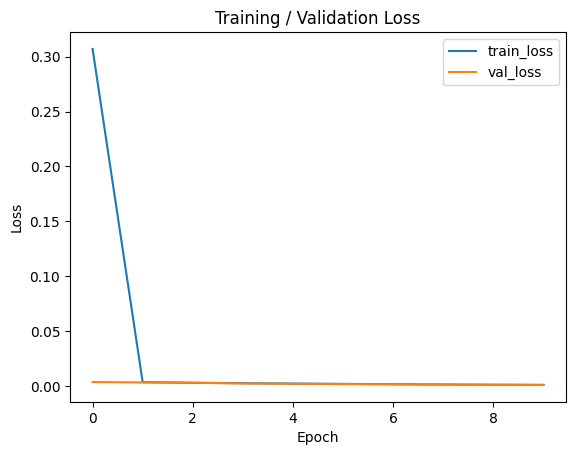

In [6]:
plt.figure()
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training / Validation Loss')
plt.show()

---
## 5) 결과 시각화

- **목적:** 모델이 실제로 “분할”을 하고 있는지, 입력/정답/예측을 나란히 비교합니다.
- **관찰 포인트**
  - 출력이 로짓이면 `sigmoid` 후 threshold(예: 0.5)로 마스크를 만드는지
  - GT 마스크와 예측 마스크의 차이가 어디에서 주로 발생하는지(경계/작은 객체/노이즈 등)
  - 데이터가 간단한데도 실패한다면: 모델 출력 채널, loss, target 타입을 다시 점검

> 숫자(loss)만 보고 넘어가면 “뭔가 학습은 되는 것 같은데 결과가 이상한” 상황을 놓치기 쉽습니다.


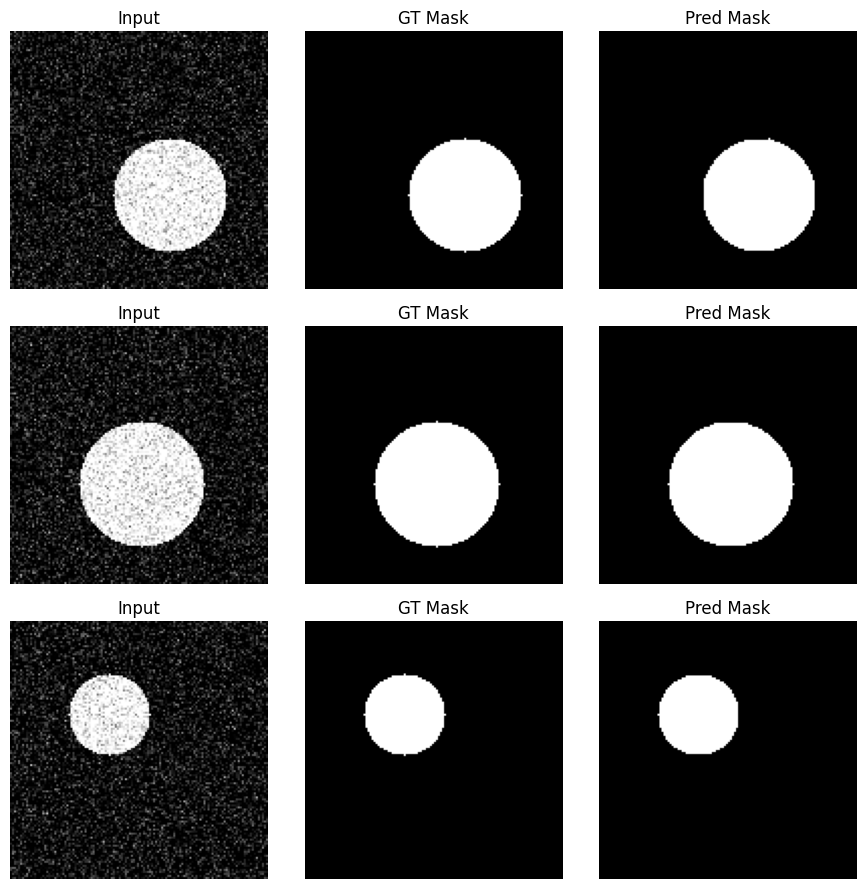

In [7]:
@torch.no_grad()
def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    imgs, masks = next(iter(dataloader))
    imgs = imgs.to(device)
    masks = masks.to(device)

    logits = model(imgs)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    imgs = imgs.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    num_samples = min(num_samples, imgs.shape[0])

    plt.figure(figsize=(9, num_samples * 3))
    for i in range(num_samples):
        # 입력
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(imgs[i, 0], cmap='gray')
        plt.title('Input')
        plt.axis('off')

        # GT mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[i, 0], cmap='gray')
        plt.title('GT Mask')
        plt.axis('off')

        # Pred mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(preds[i, 0], cmap='gray')
        plt.title('Pred Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions(model, val_loader, device, num_samples=3)